# Client code for "Deep learning-based cryptocurrency sentiment construction"

This script constructs deep learning-based indices using the approach in the paper <a href="https://papers.ssrn.com/sol3/Papers.cfm?abstract_id=3310784">"Deep learning-based cryptocurrency sentiment construction"</a>.

In [1]:
import sys
sys.path.append(r"C:\Users\chencath.sfb649\PycharmProjects\new_crypto_project/")

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import crysen

Using TensorFlow backend.


In [2]:
# ======================== Load and preprocess data ==========================
messages_file = "C:/Users/chencath.sfb649/PycharmProjects/new_crypto_project/timeline.csv"
min_term_frequency = 20
context_window = 10
embedding_dim = 256
min_msg_length = 2
max_msg_length = 50
rand_state = 21
messages_data = pd.read_csv(messages_file)

data_processor = crysen.DataProcessor(messages_data, context_window=context_window,
                                      min_msg_length=min_msg_length, train_wv=True,
                                      embedding_dim=embedding_dim, max_msg_length=max_msg_length,
                                      min_term_frequency=min_term_frequency)
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = \
    data_processor.get_train_valid_test_data(valid_size=0.1, test_size=0.1)
X_train_upsampled, Y_train_upsampled = data_processor.get_upsampled_data(X_train, Y_train, up_ratio=0.70)

Share of bearish in the train set before upsampling: 0.18443479897080495
Share of bearish in the train set after upsampling: 0.4117642573839212


In [3]:
# =========================== Build and train the model ================================
# ----- set parameters
vocab_size = data_processor.vocab_size
embed_size = embedding_dim
wv_matrix = data_processor.wv_matrix
batch_size = 64
lstm_size = 64
num_layers = 2
drop_rate = 0.5
max_sent_length = max_msg_length
start_lr = 0.1
num_epochs = 10
multiple_fc = False
fc_units = 64
decay_rate = 0.99
decay_steps = int(X_train_upsampled.shape[0]/batch_size/10)
num_classes = 2
save_path = r'C:\Users\chencath.sfb649\PycharmProjects\new_crypto_project\model_2/'

# ----- train the model
rnn = crysen.DeepRNN(lstm_size, num_layers, start_lr, embed_size, drop_rate,
                     max_sent_length, vocab_size, decay_rate, decay_steps,
                     fc_units, multiple_fc, num_classes, save_path=save_path,
                     pre_trained=True, embed_matrix=wv_matrix)
rnn.fit(X_train_upsampled, Y_train_upsampled, X_valid, Y_valid, batch_size=batch_size, epochs=num_epochs)

W1116 15:03:10.987595 10528 deprecation.py:323] From C:\Users\chencath.sfb649\PycharmProjects\new_crypto_project\crysen\deeprnn.py:133: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W1116 15:03:11.003222 10528 deprecation.py:323] From C:\Users\chencath.sfb649\PycharmProjects\new_crypto_project\crysen\deeprnn.py:76: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W1116 15:03:11.051495 10528 deprecation.py:323] From C:\Users\chencath.sfb649\PycharmProjects\new_crypto_project\crysen\deeprnn.py:83: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future ve


Epoch: 1/10; train loss: 0.5436985492706299; train acc: 0.7205820083618164; validation loss: 0.42031463980674744; validation acc: 0.8090880513191223, improvement found!

Epoch: 2/10; train loss: 0.4749731421470642; train acc: 0.7751774787902832; validation loss: 0.4262801706790924; validation acc: 0.8064136505126953, no improvement found...

Epoch: 3/10; train loss: 0.4618208706378937; train acc: 0.782397449016571; validation loss: 0.4118591845035553; validation acc: 0.8142885565757751, improvement found!

Epoch: 4/10; train loss: 0.453578919172287; train acc: 0.7864830493927002; validation loss: 0.40531641244888306; validation acc: 0.8175600171089172, improvement found!

Epoch: 5/10; train loss: 0.44804614782333374; train acc: 0.789675772190094; validation loss: 0.4015766382217407; validation acc: 0.8181467056274414, improvement found!

Epoch: 6/10; train loss: 0.4433210492134094; train acc: 0.7923955321311951; validation loss: 0.39757105708122253; validation acc: 0.82051020860672, i

In [4]:
# ----- performance check on the holdout test set
labels, predictions = rnn.predict(X_test, Y_test, batch_size=batch_size)
y_true = np.argmax(labels, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(sum(np.equal(y_pred, y_true)) / labels.shape[0])
print(classification_report(y_true, y_pred))

W1116 17:08:39.811691 10528 deprecation.py:323] From C:\Users\chencath.sfb649\AppData\Local\Continuum\anaconda3\envs\newenv\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Test accuracy: 0.830
0.8302212299573777
              precision    recall  f1-score   support

           0       0.53      0.69      0.60     10904
           1       0.93      0.86      0.89     48220

   micro avg       0.83      0.83      0.83     59124
   macro avg       0.73      0.78      0.75     59124
weighted avg       0.85      0.83      0.84     59124



In [5]:
# ============================ Sentiment index construction ==============================
# ----- load data
seed_df = pd.read_csv("C:/Users/chencath.sfb649/PycharmProjects/new_crypto_project/l2_lexicon.csv", sep=';')
crix_df = pd.read_csv("C:/Users/chencath.sfb649/PycharmProjects/new_crypto_project/crix_data.csv", index_col=0)
messages_df_full = data_processor.messages_df_with_tokens

# ----- create an index builder object
index_builder = crysen.IndexBuilder(messages_df=messages_df_full, word2idx=data_processor.word_to_index_map,
                                    w2v_matrix=rnn.trained_embed_matrix, seed_df=seed_df,
                                    min_msg_length=min_msg_length, max_msg_length=max_msg_length,
                                    rnn_model=rnn)

# ----- generate sentiments and scores
index_builder.add_classfn_sentiment()
index_builder.add_w2v_sentiment()
index_builder.add_classfn_score_1()
index_builder.add_classfn_score_2()

# ----- add CRIX
indices_scores_df = index_builder.scores_by_day_na
crix_df.index = pd.to_datetime(crix_df.index)
crix_df = crix_df.loc[:, ['crix']]
indices_scores_df_with_crix = indices_scores_df.join(crix_df)
indices_scores_df_with_crix = indices_scores_df_with_crix[indices_scores_df_with_crix.index >
                                                          pd.Timestamp('2017-01-01 00:00:00')]\
                                  .loc[:, ['crix', 'sentiment_classfn', 'sentiment_w2v']]

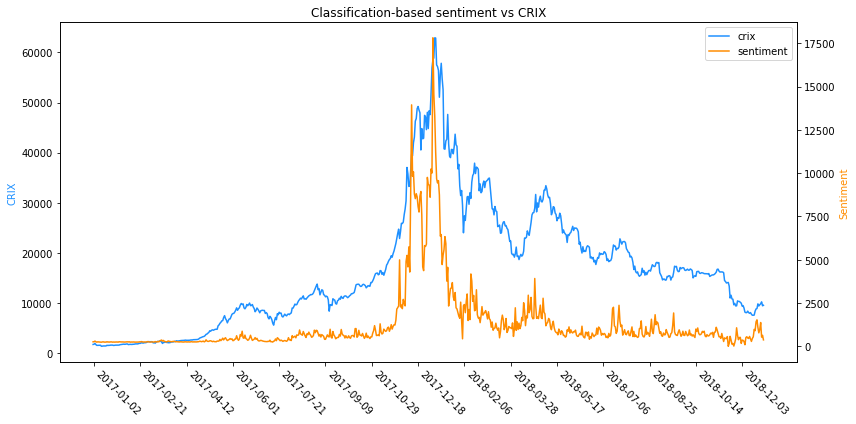

In [6]:
# ----- (1) classification-based sentiment vs CRIX
dates_labels = indices_scores_df_with_crix.index
dates_labels = [str(x)[:10] for x in dates_labels]
dates_ticks = np.arange(0, len(dates_labels), 1)
sparse_dates_ticks = np.arange(1, len(dates_labels), 50)
sparse_dates_labels = dates_labels[::50]
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax2 = ax1.twinx()
p1 = ax1.plot(dates_ticks, indices_scores_df_with_crix.crix, color="dodgerblue")
p2 = ax2.plot(dates_ticks, indices_scores_df_with_crix.sentiment_classfn, color="darkorange")
ax1.set_xticks(sparse_dates_ticks)
ax1.set_xticklabels(sparse_dates_labels, rotation=-45, ha="left")
ax2.set_ylabel("Sentiment", color="darkorange")
ax1.set_ylabel("CRIX", color="dodgerblue")
ax1.set_title("Classification-based sentiment vs CRIX")
ax1.legend([p1[0], p2[0]], ["crix", "sentiment"])
plt.tight_layout()

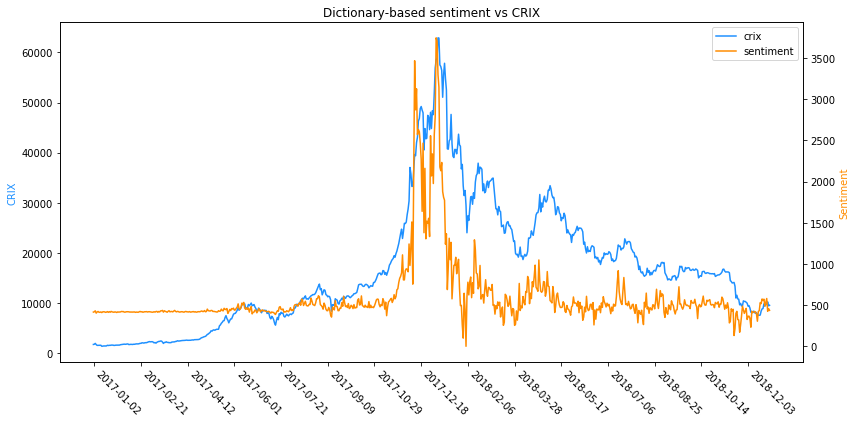

In [7]:
# ----- (2) augmented seed dictionary-based sentiment vs CRIX
dates_labels = indices_scores_df_with_crix.index
dates_labels = [str(x)[:10] for x in dates_labels]
dates_ticks = np.arange(0, len(dates_labels), 1)
sparse_dates_ticks = np.arange(1, len(dates_labels), 50)
sparse_dates_labels = dates_labels[::50]
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax2 = ax1.twinx()
p1 = ax1.plot(dates_ticks, indices_scores_df_with_crix.crix, color="dodgerblue")
p2 = ax2.plot(dates_ticks, indices_scores_df_with_crix.sentiment_w2v, color="darkorange")
ax1.set_xticks(sparse_dates_ticks)
ax1.set_xticklabels(sparse_dates_labels, rotation=-45, ha="left")
ax2.set_ylabel("Sentiment", color="darkorange")
ax1.set_ylabel("CRIX", color="dodgerblue")
ax1.set_title("Dictionary-based sentiment vs CRIX")
ax1.legend([p1[0], p2[0]], ["crix", "sentiment"])
plt.tight_layout()